# Visualizing Raw 2-Photon Images
Some Ophys NWB Files contain the raw imaging data from 2-Photon calcium imaging. The raw images, taken over time, make up a movie. Using mpl_interactions, we can view the data interactively. Since the raw data are very large, it's recommended that you stream it rather than download it.

### Environment Setup

In [1]:
from dandi import dandiapi
import dandi
import fsspec
import pynwb
import h5py
from fsspec.implementations.cached import CachingFileSystem
from nwbwidgets import nwb2widget
from matplotlib import pyplot as plt
import numpy as np
from mpl_interactions import hyperslicer

%matplotlib ipympl

### Streaming 2P File
Streaming a file from DANDI requires information about the file of interest. Set `dandiset_id` to be the ID of the dandiset you want, and set `filepath` to be the path of the file within the dandiset. The filepath can be found if you press on the `i` icon of a file and copy the `path` field that shows up in the resulting JSON. If you are accessing embargoed data, you will need to set `authenticate` to True, and `dandi_api_key` to your dandi api key.

In [5]:
dandiset_id = ""
filepath = ""
authenticate = False
dandi_api_key = ""

In [ ]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)

file = my_dandiset.get_asset_by_path(filepath)
base_url = file.client.session.head(file.base_download_url)
file_url = base_url.headers['Location']

print(f"Retrieved file url {file_url}")

In [7]:
fs = CachingFileSystem(
    fs=fsspec.filesystem("http"),
)

# opening may take awhile on a large file
f = fs.open(file_url, "rb")
file = h5py.File(f)
io = pynwb.NWBHDF5IO(file=file, mode='r', load_namespaces=True)
nwb = io.read()

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Extracting Fluorescence

In [8]:
dff = nwb.processing["ophys"]["dff"]
dff_trace = dff.roi_response_series["traces"].data
dff_timestamps = dff.roi_response_series["traces"].timestamps

print(dff_timestamps.shape)
print(dff_trace.shape)

flr = nwb.processing["ophys"]["corrected_fluorescence"]
flr_trace = flr.roi_response_series["traces"].data
flr_timestamps = flr.roi_response_series["traces"].timestamps

print(flr_timestamps.shape)
print(flr_trace.shape)

(42337,)
(42337, 98)
(42337,)
(42337, 98)


### Extracting Regions of Interest

In [9]:
roi_masks = np.array(nwb.processing["ophys"]["images"]["segmentation_mask_image"])
print(roi_masks.shape)

(512, 512)


### Extracting 2P Movie

In [10]:
two_p = nwb.acquisition["raw_suite2p_motion_corrected"].data
print(two_p.shape)

(42337, 512, 512)


### Viewing the Data
You can view the Fluorescence and DF/F traces below with matplotlib. You can set an individual `roi` whose fluorescence trace to view. If `roi` is None, it will plot all of them. You can also view the 2P video with mpl_interactions.hyperslicer. The number of frames is printed in the first cell below. Because the image data are so large, it is advised the you select a subsection of these images to view. Set `start_frame` to the first image you want to be displayed, and `end_frame` to be the last. The larger this interval, the longer it will take to display. It is recommended the interval is less than 2000.

In [11]:
start_frame = 0
end_frame = start_frame + 200
roi = None

#### Fluorescence Trace

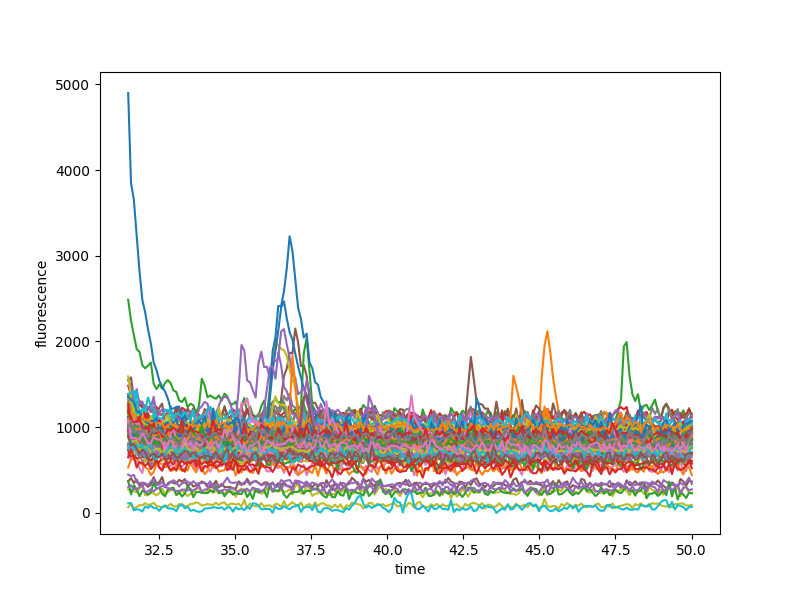

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
if roi == None:
    ax.plot(flr_timestamps[start_frame: end_frame], flr_trace[start_frame: end_frame])
else:
    ax.plot(flr_timestamps[start_frame: end_frame], flr_trace[start_frame: end_frame, roi])

plt.ylabel("fluorescence")   
plt.xlabel("time")
plt.show()

#### DFF Trace

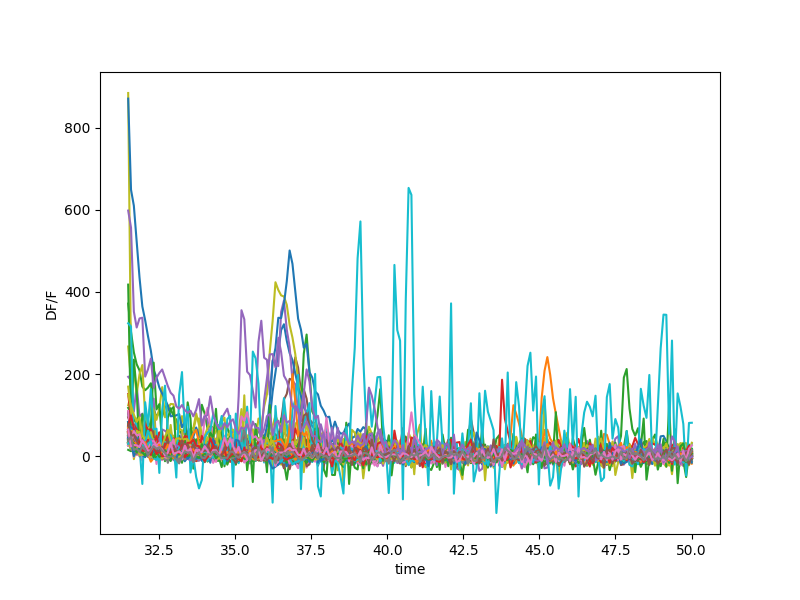

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
if roi == None:
    ax.plot(dff_timestamps[start_frame: end_frame], dff_trace[start_frame: end_frame]*100)
else:
    ax.plot(dff_timestamps[start_frame: end_frame], dff_trace[start_frame: end_frame, roi]*100)

plt.ylabel("DF/F")
plt.xlabel("time")
plt.show()

#### Regions of Interest Mask

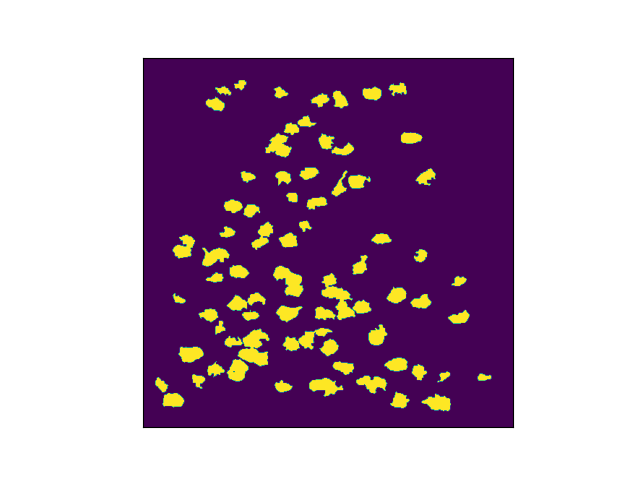

In [14]:
fig, ax = plt.subplots()
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.imshow(roi_masks)

#### 2P Movie with ROI Mask

In [15]:
### overlaying ROIs onto 2p movie
two_p_subset = np.array(two_p[start_frame:end_frame])
roi_masks_3d = np.reshape(roi_masks, (1,) + roi_masks.shape)
m = two_p_subset.mean()
roi_masks_3d = np.multiply(roi_masks_3d, m*10)
two_p_masked = np.add(two_p_subset, roi_masks_3d)

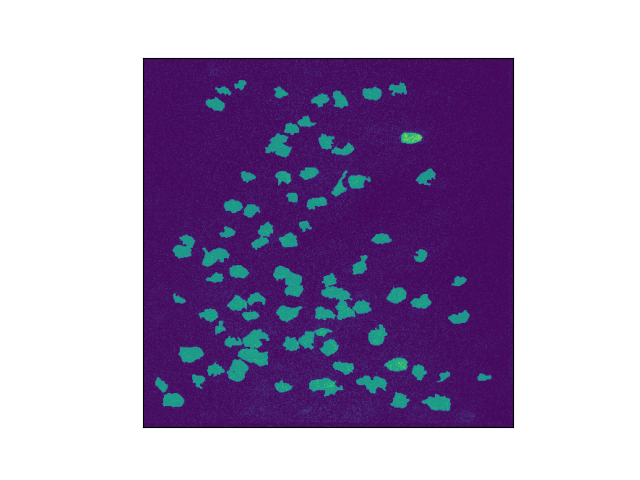

In [16]:
fig, ax = plt.subplots()
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
view = hyperslicer(two_p_masked,play_buttons=True)